# Explaining some causes behind different project riks 
## Scenarios number 1

### What are the effects of different variables on average cyclomatic complexity? 
- Task: Effect estimation

In [1]:
# Imports
import pandas as pd
import numpy as np
import pygraphviz
import matplotlib.pyplot as plt
import dowhy
import networkx as nx
from dowhy import CausalModel
from dowhy import gcm

#### Initialization

In [2]:
data_path = "../data/useable/vue/clean_tasks.csv"
dataset = pd.read_csv(data_path)

# # Filter the dataset to include only rows after 2019 based on "authored_at" column
dataset = dataset[dataset['authored_at'] > '2017-01-01']

print(len(dataset))

# Display the first few rows of the filtered dataset
dataset.head()

1436


,task_type,has_bug_fixing,has_code_refactoring,loc,files_touched,author,committer,authored_at,commited_at,commit_time_in_day,...,communication,total_nloc,avg_nloc,avg_ccn,avg_token,fun_cnt,warning_cnt,fun_rate,nloc_rate,duration
1333,2,1,0,4,1,118,243,2017-01-02 16:38:02,2017-01-02 16:38:02,3,...,1,67543,8.8,2.9,58.0,6815,119,0.02,0.08,0.0
1334,3,0,1,46,2,69,243,2017-01-02 16:45:42,2017-01-02 16:45:42,3,...,1,67530,8.8,2.9,58.0,6813,119,0.02,0.08,0.0
1335,2,1,0,119,4,69,243,2017-01-04 19:43:52,2017-01-04 19:43:52,4,...,1,67613,8.8,2.9,58.0,6827,119,0.02,0.08,0.0
1336,7,0,0,2,1,20,243,2017-01-04 19:44:02,2017-01-04 19:44:02,4,...,1,67613,8.8,2.9,58.0,6827,119,0.02,0.08,0.0
1337,1,0,0,8,1,243,243,2017-01-05 02:37:53,2017-01-05 02:37:53,1,...,0,67613,8.8,2.9,58.0,6827,119,0.02,0.08,0.0


### Step-1. Create a Causal Graph

Assumptions:
The potential treatment variables that can affect average cyclomatic complexity are:

1. Task-related variables:
    - task_type
    - has_bug_fixing
    - has_code_refactoring

2. Code-related variables:
    - loc
    - files_touched
    - contribution_complexity

3. People-related variables:
    - author
    - committer
    - author_experience
    - committer_experience
    - communication

4. Time-related variables:
    - authored_at
    - commited_at
    - commit_time_in_day
    - duration

In [1]:
causal_graph = """
    digraph {
        task_type [label="Task Type"];
        loc [label="Lines of Code (LOC)"];
        files_touched [label="Number of Files Touched"];
        author [label="Author"];
        committer [label="Committer"];
        communication [label="Communication"];
        author_experience [label="Author Experience"];
        committer_experience [label="Committer Experience"];
        contribution_complexity [label="Contribution Complexity"];
        avg_token [label="Avg. token count of functions."];
        total_nloc [label="Total lines of code without comments"];
        avg_ccn [label="Avg. Cyclomatic Complexity Number"];
        has_bug_fixing [label="Has bug fixing?"];
        has_code_refactoring [label="Has code refactoring?"];
        U[label="Unobserved confounders"];
        U->communication;
        
        task_type -> has_bug_fixing;
        task_type -> has_code_refactoring;
        loc -> total_nloc;
        total_nloc -> avg_nloc;
        total_nloc -> avg_token;
        has_bug_fixing -> avg_ccn;
        has_code_refactoring -> avg_ccn;
        files_touched -> avg_ccn;
        author -> avg_ccn;
        author_experience -> avg_ccn;
        committer_experience -> avg_ccn;
        communication -> avg_ccn;
        contribution_complexity -> avg_ccn;
        committer -> avg_ccn;
        author -> contribution_complexity;
        has_bug_fixing -> contribution_complexity;
        has_code_refactoring -> contribution_complexity;
        total_nloc -> contribution_complexity;
        committer -> contribution_complexity;
        files_touched -> contribution_complexity;
        author_experience -> contribution_complexity;
        committer_experience -> contribution_complexity;
        communication -> contribution_complexity;
        committer -> communication;
        author -> communication;
    }
"""


In the given directed acyclic graph, the Treatment is the **communication**. The outcome is whether a higher value in code quality is achieved. The Common causes represent the variables that affect both the Treatment and Outcome. According to the assumed causal relationships, the common causes in this case are the experience and expertise of the author and committer, the contribution complexity, the communication and collaboration between team members, and the duration of the task. If the graph is not explicitly defined, these common causes can be provided as parameters in the function used for analysis.

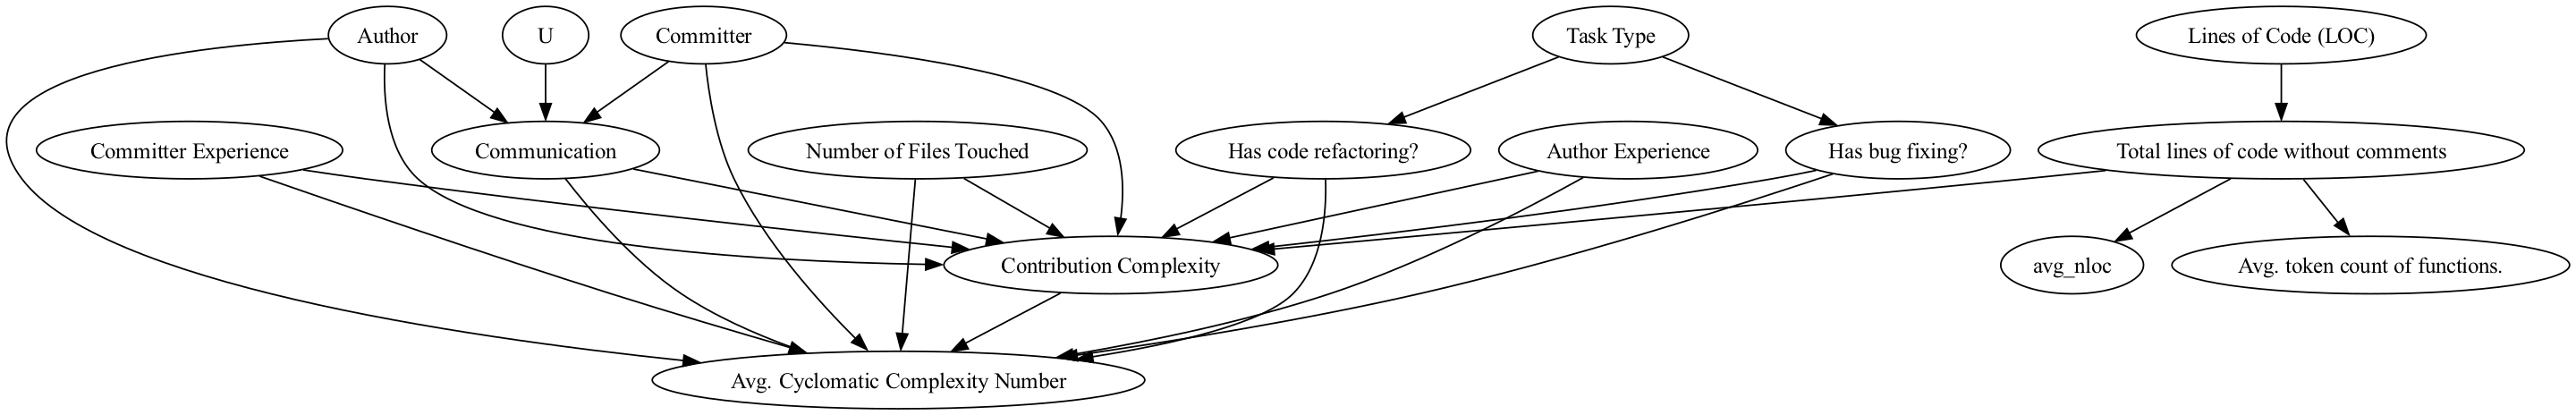

In [4]:
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment="contribution_complexity",
        outcome='avg_ccn')
model.view_model(layout='dot',file_name="causal_model_q1", size=(30, 15))
from IPython.display import Image, display
display(Image(filename="causal_model_q1.png"))

### Step-2. Identify the Causal Effect

We say that Treatment causes Outcome if changing Treatment leads to a change in Outcome keeping everything else constant. Thus in this step, by using properties of the causal graph, we identify the causal effect to be estimated

In [5]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True, method_name="maximal-adjustment")
print(identified_estimand)


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                                                                                  
──────────────────────────(E[avg_ccn|has_code_refactoring,author,author_⟨experience,⟩_token,committer,files_touched,task_type,total_⟨nloc,commu
d[contribution_complexity]                                                                                                                     

                                                         
nication,loc,⟩_nloc,committer_experience,has_bug_fixing])
                                                         
Estimand assumption 1, Unconfoundedness: If U→{contribution_complexity} and U→avg_ccn then P(avg_ccn|contribution_complexity,has_code_refactoring,author,author_experience,avg_token,committer,files_touched,task_type,total_nloc,communication,loc,avg_nloc,committer_experience,has_bug_fi

### Step-3. Estimate the identified estimand

In [6]:
causal_estimate_iv = model.estimate_effect(identified_estimand, method_name="iv.instrumental_variable")
print(causal_estimate_iv)
print("Causal Estimate is " + str(causal_estimate_iv.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                                                 -1⎤
 ⎢      d                ⎛      d                                 ⎞  ⎥
E⎢─────────────(avg_ccn)⋅⎜─────────────([contribution_complexity])⎟  ⎥
 ⎣d[total_nloc]          ⎝d[total_nloc]                           ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→avg_ccn then ¬(U →→{total_nloc})
Estimand assumption 2, Exclusion: If we remove {total_nloc}→{contribution_complexity}, then ¬({total_nloc}→avg_ccn)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
 ⎡     d              ⎤  -1⎡     d                              ⎤
E⎢───────────(avg_ccn)⎥⋅E  ⎢───────────(contribution_complexity)⎥
 ⎣dtotal_nloc         ⎦    ⎣dtotal_nloc                         ⎦
Estimand assumption 1, As-if-random: If U→→

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/dowhy/causal_estimators/instrumental_variable_estimator.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  iv_est = num_yz / deno_xz


In [7]:
causal_estimate = model.estimate_effect(identified_estimand,test_significance=True, 
                                         method_name="backdoor.linear_regression")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                                                                                  
──────────────────────────(E[avg_ccn|has_code_refactoring,author,author_⟨experience,⟩_token,committer,files_touched,task_type,total_⟨nloc,commu
d[contribution_complexity]                                                                                                                     

                                                         
nication,loc,⟩_nloc,committer_experience,has_bug_fixing])
                                                         
Estimand assumption 1, Unconfoundedness: If U→{contribution_complexity} and U→avg_ccn then P(avg_ccn|contribution_complexity,has_code_refactoring,author,author_experience,avg_token,committer,files_touched,task_type,total_nloc,communicat

### Step-4: Refute obtained results

#### Method-1

Bootstrap refuter:- It works by randomly sampling a dataset with replacement to create multiple "bootstrap samples," which are samples of the same size as the original dataset but with some of the observations repeated and others left out. If our assumption was originally correct then the causal estimate shouldn’t change by much.


In [14]:
ref = model.refute_estimate(identified_estimand, causal_estimate, method_name="bootstrap_refuter")
print(ref)

Refute: Bootstrap Sample Dataset
Estimated effect:-0.14677847244853126
New effect:-0.14601284372317175
p value:0.94



#### Method-2
Placebo Treatment Refuter:- Randomly assigns any covariate as a treatment and re-runs the analysis. If our assumptions were correct then this newly found out estimate should go to 0.

In [17]:
ref = model.refute_estimate(identified_estimand, causal_estimate, method_name="placebo_treatment_refuter", 
                            placebo_type="permute") # only permute placebo_type works with IV estimate
print(ref)

Refute: Use a Placebo Treatment
Estimated effect:-0.14677847244853126
New effect:-0.0003242777697585986
p value:0.8600000000000001



The p-value in a placebo treatment refuter tells us the probability of obtaining a result as extreme or more extreme than the observed result if there is no actual effect of the treatment. In other words, it tells us the strength of evidence against the null hypothesis, which is that the treatment has no effect.

If the p-value is very small (typically less than 0.05), we can conclude that the observed result is unlikely to have occurred by chance alone, and we reject the null hypothesis in favor of the alternative hypothesis that the treatment has a real effect. However, it's important to note that statistical significance (as indicated by a small p-value) does not necessarily mean that the observed effect is large or clinically meaningful.

It's also worth noting that the p-value is not the only consideration in interpreting the results of a study. Other factors, such as the study design, sample size, and potential sources of bias, should also be taken into account.

#### Method-3
Data Subset Refuter:- Creates subsets of the data(similar to cross-validation) and checks whether the causal estimates vary across subsets. If our assumptions were correct there shouldn’t be much variation.

In [16]:
# Refute the estimate using the Data Subset Refuter
ref = model.refute_estimate(identified_estimand, causal_estimate, method_name="data_subset_refuter")
print(ref)

Refute: Use a subset of data
Estimated effect:-0.14677847244853126
New effect:-0.1468981318277483
p value:0.98



-- The end --